In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

In [2]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
data = pd.read_csv('F:/3.Suresh/1.Material/05.Data Science/22_Data Sets/GitHub/creditcard.csv', sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [4]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


## Exploratory Data Analysis

In [5]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

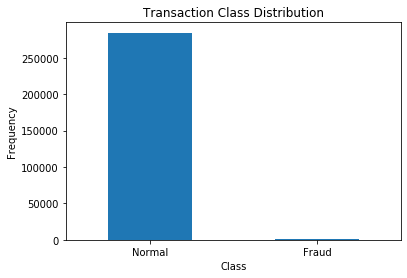

In [6]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [7]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [8]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


### 1. SMOTETomek

In [9]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [10]:
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_sample(X,Y)

In [11]:
X_res.shape,y_res.shape

((567562, 30), (567562,))

In [12]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 283781, 1: 283781})


-----------------------

## 2. SMOTE (Synthetic Minority Over-sampling Technique)

- The second resampling technique is called, Oversampling. This process is a little more complicated than undersampling. It is the process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class. There are a number of methods used to oversample a dataset for a typical classification problem. The most common technique is called SMOTE (Synthetic Minority Over-sampling Technique). In simple terms, it looks at the feature space for the minority class data points and considers its k nearest neighbours.


- To code this in python, I use a library called imbalanced-learn or imblearn. The code below shows how to implement SMOTE.

In [6]:
# Shuffle the Dataset.
shuffled_df = data.sample(frac=1, random_state=4)

# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=492, random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])

In [7]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(data.drop('Class', axis=1), data['Class'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = normalized_df.columns

- Remember when I said how imbalanced data would affect the feature correlation? Let me show you the correlation before and after treating the imbalanced class.

### Before Resampling:
- The code below plots the correlation matrix between all the features.

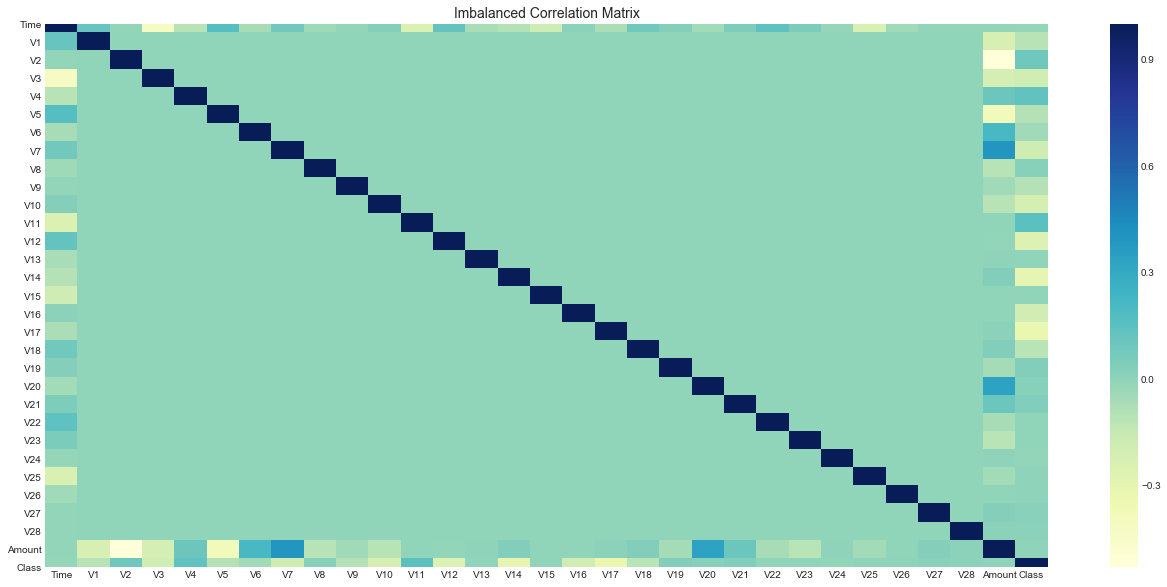

In [8]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = data.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

### After Resampling:

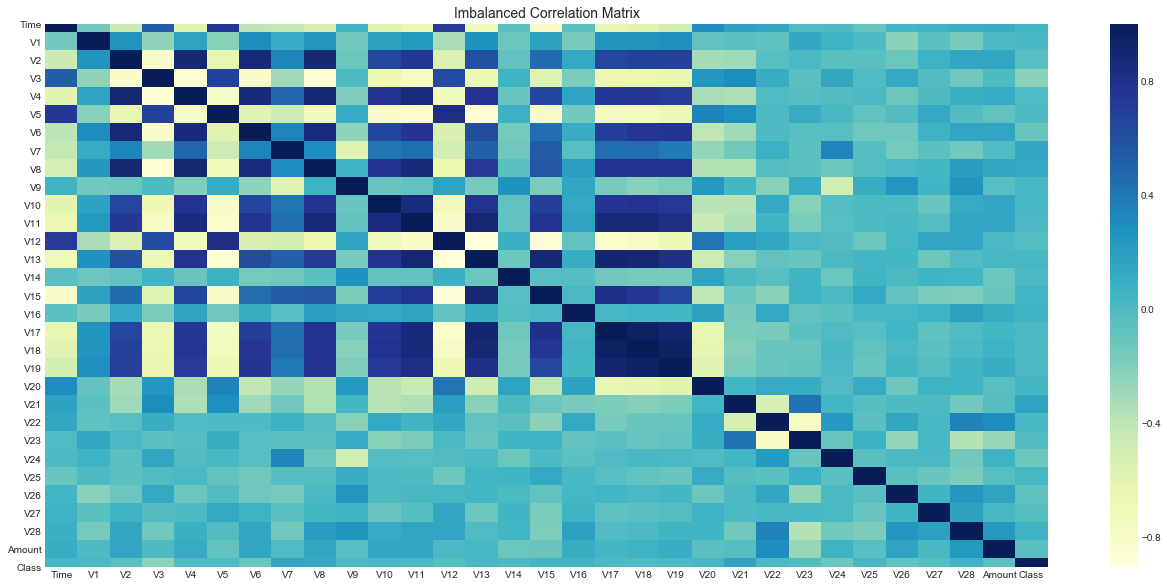

In [9]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = oversampled_train.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

- Notice that the feature correlation is much more obvious now. Before fixing the imbalance problem, most of the features did not show any correlation which would definitely have impacted the performance of the model. Since the feature correlation really matters to the overall model’s performance, it is important to fix the imbalance as it will also impact the ML model performance.

--------------------